In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import env

# DBSCAN import
from sklearn.cluster import DBSCAN
# Scaler import
from sklearn.preprocessing import MinMaxScaler

### 1. Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.

In [79]:
query = '''
        SELECT *
        FROM grocery_customers
'''

In [80]:
df = pd.read_sql(query, env.conn('grocery_db'))

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   customer_id       440 non-null    int64
 1   Channel           440 non-null    int64
 2   Region            440 non-null    int64
 3   Fresh             440 non-null    int64
 4   Milk              440 non-null    int64
 5   Grocery           440 non-null    int64
 6   Frozen            440 non-null    int64
 7   Detergents_Paper  440 non-null    int64
 8   Delicassen        440 non-null    int64
dtypes: int64(9)
memory usage: 31.1 KB


In [82]:
df.columns = df.columns.str.lower()

In [83]:
df.head()

,customer_id,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185


In [84]:
df['total'] = df.fresh + df.milk + df.grocery + df.frozen + df.detergents_paper + df.delicassen

In [85]:
df.total.sort_values(ascending = False)

85     199891
47     192714
181    190169
183    185683
61     165881
        ...  
131      3730
355      3485
98       2476
97       2158
154       904
Name: total, Length: 440, dtype: int64

In [86]:
# df = df.drop(columns = 'customer_id')

In [87]:
df.head()

,customer_id,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen,total
0,0,2,3,12669,9656,7561,214,2674,1338,34112
1,1,2,3,7057,9810,9568,1762,3293,1776,33266
2,2,2,3,6353,8808,7684,2405,3516,7844,36610
3,3,1,3,13265,1196,4221,6404,507,1788,27381
4,4,2,3,22615,5410,7198,3915,1777,5185,46100


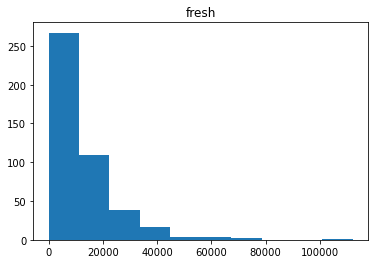

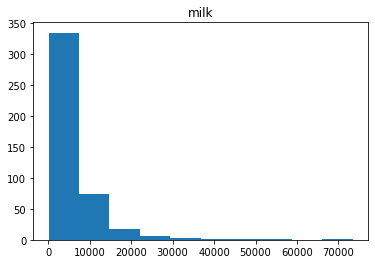

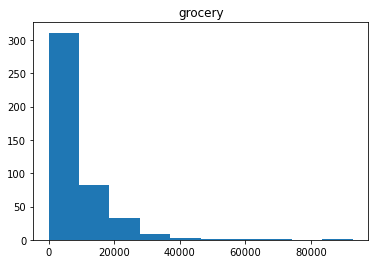

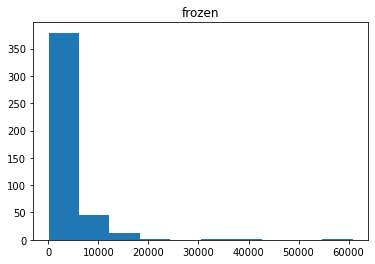

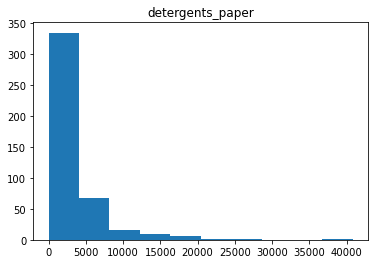

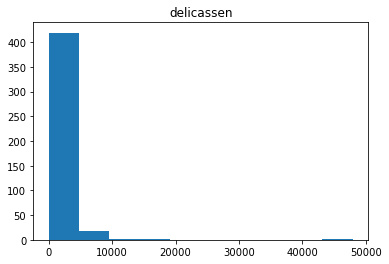

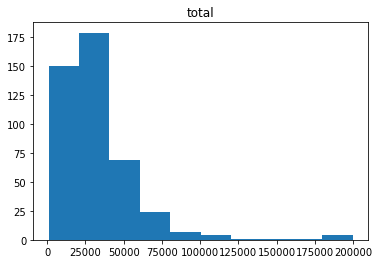

In [88]:
cols = ['fresh', 'milk', 'grocery', 'frozen', 'detergents_paper', 'delicassen', 'total']
for col in cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [89]:
df.columns

Index(['customer_id', 'channel', 'region', 'fresh', 'milk', 'grocery',
       'frozen', 'detergents_paper', 'delicassen', 'total'],
      dtype='object')

In [91]:
temp = df.customer_id

In [92]:
df = df[['fresh', 'frozen']]

In [93]:
scaler = MinMaxScaler().fit(df)
scaled_df = scaler.transform(df)

In [94]:
s_cols = [col + '_scaled' for col in df.columns]
s_cols

['fresh_scaled', 'frozen_scaled']

In [95]:
scaled_df = pd.DataFrame(scaled_df, columns=s_cols, index=df.index)

In [96]:
dbse = DBSCAN(eps=.1, min_samples=20).fit(scaled_df)

In [99]:
df['customer_id'] = temp

In [100]:
scaled_df['customer_id'] = temp

In [101]:
df = df.merge(scaled_df, on=df.customer_id).drop(columns='key_0')

In [102]:
df['labels'] = dbse.labels_

In [103]:
df[df.labels == -1]

,fresh,frozen,customer_id_x,fresh_scaled,frozen_scaled,customer_id_y,labels
39,56159,10002,39,0.500731,0.163977,39,-1
93,11314,35009,93,0.100858,0.574979,93,-1
103,56082,18028,103,0.500045,0.295888,103,-1
125,76237,16538,125,0.679762,0.271399,125,-1
181,112151,16745,181,1.000000,0.274801,181,-1
183,36847,36534,183,0.328530,0.600043,183,-1
196,30624,18711,196,0.273041,0.307113,196,-1
258,56083,6422,258,0.500054,0.105138,258,-1
284,68951,8692,284,0.614795,0.142446,284,-1
325,32717,60869,325,0.291704,1.000000,325,-1


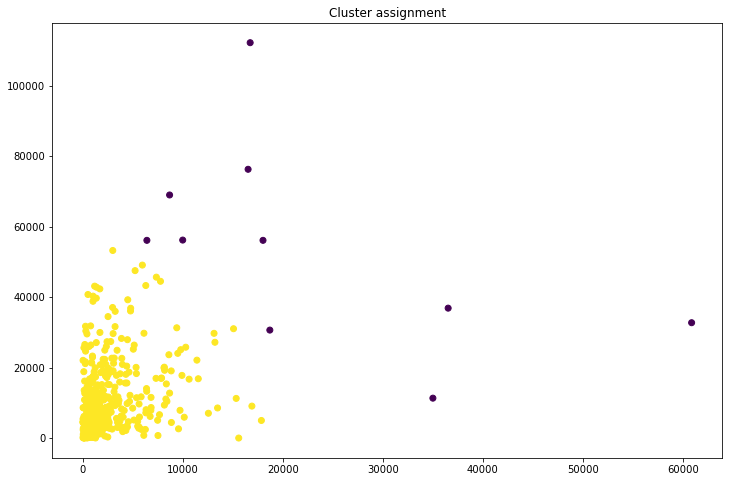

In [105]:
plt.figure(figsize=(12,8))
plt.scatter(df['frozen'], df['fresh'], c=df['labels'])
plt.title('Cluster assignment')
plt.show()

### 2. Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [36]:
logs = pd.read_table("curriculum-access.txt", sep = '\s', header = None, 
                   names = ['date', 'time', 'page', 'id', 'cohort', 'ip'])

/var/folders/tg/htdzmdmj40vgs24scqz284xm0000gn/T/ipykernel_25331/3925225685.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  logs = pd.read_table("curriculum-access.txt", sep = '\s', header = None,


In [37]:
logs.head()

,date,time,page,id,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,98.106.20.62
1,2018-01-26,09:56:02,java-ii,1,8.0,98.106.20.62
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,98.106.20.62
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62


In [38]:
logs['date'] = pd.to_datetime(logs['date'])

In [39]:
# logs = logs.set_index('date', drop=True)

In [40]:
logs.groupby(['id', 'date'])['page'].count()[logs.groupby(['id', 'date'])['page'].count() > 190]

id   date      
138  2018-06-02    198
313  2018-12-19    225
341  2019-03-03    272
422  2019-07-25    253
526  2019-12-19    192
570  2020-04-05    232
     2020-04-16    271
     2020-04-26    234
Name: page, dtype: int64

In [41]:
logs.groupby('id').page.count().sort_values(ascending=False).head(10)

id
11     11065
64     10784
53      9534
1       5437
344     5370
314     4695
570     3403
423     3281
211     3256
315     2998
Name: page, dtype: int64

### 3. Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [2]:
df = pd.read_csv('zillow.csv').iloc[:,1:]

In [3]:
import zillow_wrangle

In [4]:
df = zillow_wrangle.prepare_zillow(df)

In [5]:
df = df[['beds', 'area']]
df

,beds,area
0,4.0,3100.0
1,2.0,1465.0
2,3.0,1243.0
3,4.0,2376.0
4,4.0,2962.0
...,...,...
52436,4.0,2440.0
52437,2.0,1286.0
52438,3.0,1032.0
52439,4.0,1612.0


In [6]:
scaler = MinMaxScaler().fit(df)
scaled_df = scaler.transform(df)

In [7]:
s_cols = [col + '_scaled' for col in df.columns]
s_cols

['beds_scaled', 'area_scaled']

In [8]:
scaled_df = pd.DataFrame(scaled_df, columns=s_cols, index=df.index)

In [9]:
dbsc = DBSCAN(eps=.1, min_samples=20).fit(scaled_df)

In [10]:
dbsc.labels_.shape

(50698,)

In [11]:
scaled_df.shape

(50698, 2)

In [12]:
df = df.merge(scaled_df, on=df.index).drop(columns='key_0')

In [13]:
df['labels'] = dbsc.labels_

In [14]:
df[df.labels == -1]

,beds,area,beds_scaled,area_scaled,labels
672,0.0,5782.0,0.000000,0.259346,-1
2271,9.0,9918.0,0.818182,0.449062,-1
2537,4.0,12039.0,0.363636,0.546351,-1
3291,8.0,11703.0,0.727273,0.530939,-1
4786,8.0,21929.0,0.727273,1.000000,-1
7387,9.0,7970.0,0.818182,0.359708,-1
12800,8.0,11649.0,0.727273,0.528462,-1
15843,7.0,20612.0,0.636364,0.939590,-1
21078,11.0,4012.0,1.000000,0.178157,-1
25841,9.0,8932.0,0.818182,0.403835,-1


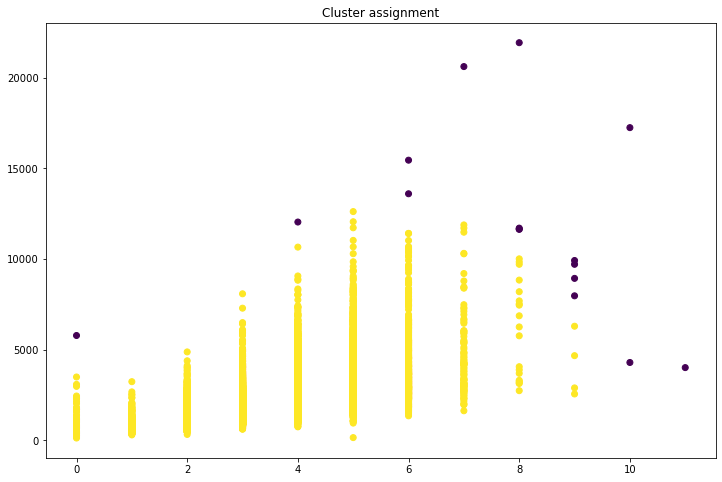

In [15]:
plt.figure(figsize=(12,8))
plt.scatter(df['beds'], df['area'], c=df['labels'])
plt.title('Cluster assignment')
plt.show()